## Image sample (DDPM - guided diffusion - Diffusion beats gans)

In [14]:
# from __future__ import print_function 
import argparse
import os, sys, glob

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0, 1, 2, 3"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch as th
import PIL
import pytorch_lightning as pl
sys.path.insert(0, '../')
from guided_diffusion.script_util import (
    seed_all,
)
import importlib

# Sample utils
from sample_utils import ckpt_utils, params_utils, vis_utils, file_utils, img_utils, inference_utils
importlib.reload(ckpt_utils)
importlib.reload(params_utils)
importlib.reload(vis_utils)
importlib.reload(file_utils)
importlib.reload(img_utils)
importlib.reload(inference_utils)


creating the FLAME Decoder


<module 'sample_utils.inference_utils' from '/home/mint/guided-diffusion/sample_scripts/sample_utils/inference_utils.py'>

In [16]:
# Settings 

# List model_logs
# cfg_name = "cond_img64_by_deca_arcface.yaml"
# log_dir = "img64_cond_by_deca_arcface"
# cfg_name = "imgsize_64_condition.yaml"
# log_dir = "imgsize_64_condition"
cfg_name = "cond_img64_by_deca_arcface.yaml"
log_dir = "cond_img64_by_deca_arcface"
set_ = "valid"

step = "100000"
ckpt_selector = "ema"
ckpt_loader = ckpt_utils.CkptLoader(log_dir=log_dir, cfg_name=cfg_name)
cfg = ckpt_loader.cfg
img_model, diffusion = ckpt_loader.load_model(ckpt_selector=ckpt_selector, step=step)


['/data/mint/model_logs_mount/v9/cond_img64_by_deca_arcface/']
Merging with :  Namespace(cfg='../config/Various_condition_on_Image/cond_img64_by_deca_arcface.yaml')

Available ckpt :  ['_000000.pt', '_050000.pt', '_100000.pt']


In [3]:
# Load params
params_key = ['shape', 'pose', 'exp', 'cam', 'light', 'faceemb']
params_train, params_train_arr = params_utils.load_params(path="/data/mint/ffhq_256_with_anno/params/train/", params_key=params_key)
params_valid, params_valid_arr = params_utils.load_params(path="/data/mint/ffhq_256_with_anno/params/valid/", params_key=params_key)

Key=> shape : Filename=>/data/mint/ffhq_256_with_anno/params/train/ffhq-train-shape-anno.txt
Key=> pose : Filename=>/data/mint/ffhq_256_with_anno/params/train/ffhq-train-pose-anno.txt
Key=> exp : Filename=>/data/mint/ffhq_256_with_anno/params/train/ffhq-train-exp-anno.txt
Key=> cam : Filename=>/data/mint/ffhq_256_with_anno/params/train/ffhq-train-cam-anno.txt
Key=> light : Filename=>/data/mint/ffhq_256_with_anno/params/train/ffhq-train-light-anno.txt
Key=> faceemb : Filename=>/data/mint/ffhq_256_with_anno/params/train/ffhq-train-faceemb-anno.txt
Key=> shape : Filename=>/data/mint/ffhq_256_with_anno/params/valid/ffhq-valid-shape-anno.txt
Key=> pose : Filename=>/data/mint/ffhq_256_with_anno/params/valid/ffhq-valid-pose-anno.txt
Key=> exp : Filename=>/data/mint/ffhq_256_with_anno/params/valid/ffhq-valid-exp-anno.txt
Key=> cam : Filename=>/data/mint/ffhq_256_with_anno/params/valid/ffhq-valid-cam-anno.txt
Key=> light : Filename=>/data/mint/ffhq_256_with_anno/params/valid/ffhq-valid-light-an

In [17]:
# Load image for condition (if needed)
img_dataset_path = f'/data/mint/ffhq_256_with_anno/ffhq_256/{set_}/'
all_files = file_utils._list_image_files_recursively(img_dataset_path)

In [21]:
batch_size = 20
base_idx = 12
mode = {'init_noise':'fixed_noise', 'cond_params':'vary_cond'}
interchange=['pose']

if set_ == 'train':
    params_set = params_train
elif set_ == 'valid':
    params_set = params_valid
else:
    raise NotImplementedError

seed_all(23)
im = inference_utils.InputManipulate(cfg=cfg, params=params_set, batch_size=batch_size)
init_noise, model_kwargs = im.prep_model_input(params_set=params_set, mode=mode, interchange=interchange, base_idx=base_idx)


In [22]:
pl_inference = inference_utils.PLSampling(img_model=img_model, diffusion=diffusion, cfg=cfg, sample_fn=diffusion.ddim_sample_loop)
sample_ddim = pl_inference(noise=init_noise, model_kwargs=model_kwargs)

  0%|          | 0/1000 [00:00<?, ?it/s]

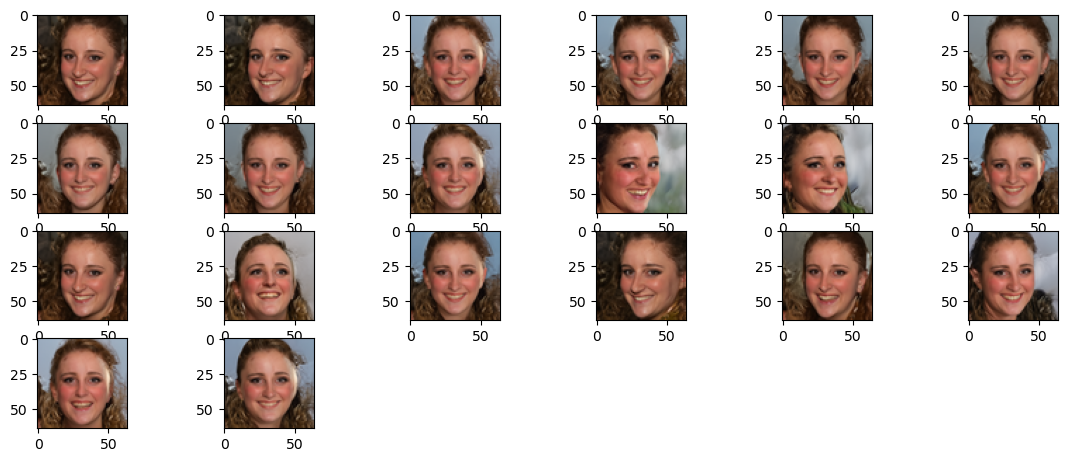

Use conditioning


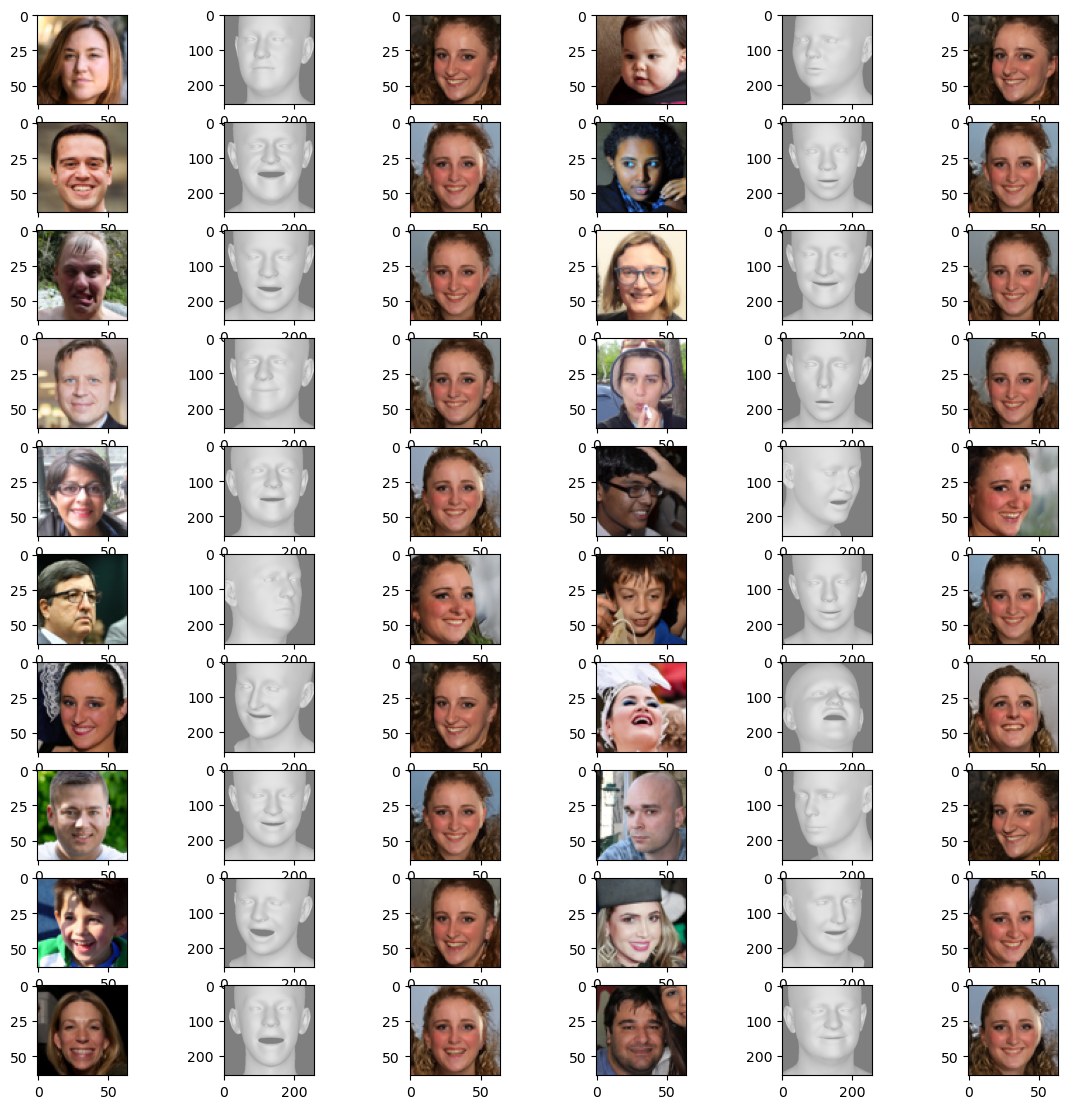

In [23]:
vis_utils.plot_sample(img=sample_ddim['img_output'])
src_img_list, render_img_list = im.get_image(model_kwargs=model_kwargs, params=params_set, img_dataset_path=img_dataset_path)
src_img = th.cat(src_img_list, dim=0)
render_img = th.cat(render_img_list, dim=0)
vis_utils.plot_sample(img=src_img, render_img=render_img, sampling_img=sample_ddim['img_output'])

# In-the-wild Images

In [ ]:
# In-the-wild Image
import torch as th
import sys, os

sys.path.insert(0, './cond_utils/arcface/')
sys.path.insert(0, './cond_utils/arcface/detector/')
sys.path.insert(0, './cond_utils/deca/')
from cond_utils.arcface import get_arcface_emb
from cond_utils.deca import get_deca_emb
itw_path = "./itw_images/"
device = 'cuda:2'

# ArcFace
faceemb_itw, emb = get_arcface_emb.get_arcface_emb(img_path=itw_path, device=device)

# DECA
params_dict = {'shape':100, 'pose':6, 'exp':50, 'cam':3, 'light':27, 'faceemb':512,}
deca_itw = get_deca_emb.get_deca_emb(img_path=itw_path, device=device)

assert deca_itw.keys() == faceemb_itw.keys()
params_itw = {}
for img_name in deca_itw.keys():
    params_itw[img_name] = deca_itw[img_name]
    params_itw[img_name].update(faceemb_itw[img_name])

In [ ]:
batch_size = len(params_itw)
seed_all(47)
base_idx = 3
itw_mode = {'init_noise':'fixed_noise', 'cond_params':'vary_cond'}

im_itw = inference_utils.InputManipulate(cfg=cfg, params=params_itw, batch_size=batch_size, sorted=True)
itw_noise = im_itw.get_init_noise(mode=mode['init_noise'], img_size=cfg.img_model.image_size)
itw_kwargs = im_itw.load_condition(params=params_itw)

itw_src_img_list = []
for img_name in itw_kwargs['image_name']:
    itw_src_img = PIL.Image.open(itw_path + img_name).resize((cfg.img_model.image_size, cfg.img_model.image_size))
    itw_src_img = (th.tensor(np.transpose(itw_src_img, (2, 0, 1)))[None, :] / 127.5) - 1
    itw_src_img_list.append(itw_src_img)

itw_src_img = th.cat(itw_src_img_list, dim=0)

In [ ]:
# Interchange the condition
itw_kwargs['cond_params'] = im_itw.interchange_condition(interchange=['pose'], base_idx=base_idx, cond_params=itw_kwargs['cond_params'])

# Sampling
pl_inference = inference_utils.PLSampling(img_model=img_model, diffusion=diffusion, cfg=cfg, sample_fn=diffusion.ddim_sample_loop)
itw_sample_ddim = pl_inference(noise=itw_noise, model_kwargs=itw_kwargs)
vis_utils.plot_sample(img=itw_src_img, sampling_img=itw_sample_ddim['img_output'])


# DDIM Inversion

In [ ]:
itw_path = "./itw_images/"
device = 'cuda:0'
base_idx = 3
all_itw_files = file_utils._list_image_files_recursively(itw_path)
itw_images = th.tensor(np.stack([img_utils.prep_images(all_itw_files[i], cfg.img_model.image_size) for i in range(len(all_itw_files))], axis=0)).to(device)

im_itw = inference_utils.InputManipulate(cfg=cfg, params=params_itw, batch_size=len(params_itw), sorted=True)
itw_kwargs = im_itw.load_condition(params=params_itw)
itw_kwargs['cond_params'] = itw_kwargs['cond_params'].to(device)

# Reverse
# pl_reverse_sampling = inference_utils.PLReverseSampling(img_model=img_model, diffusion=diffusion, sample_fn=diffusion.ddim_reverse_sample_loop, cfg=cfg)
pl_reverse_sampling = inference_utils.PLReverseSampling(img_model=img_model, diffusion=diffusion, sample_fn=diffusion.q_sample, cfg=cfg)
reverse_ddim_sample = pl_reverse_sampling(x=itw_images, model_kwargs=itw_kwargs)

# Forward
itw_kwargs['cond_params'] = im_itw.interchange_condition(interchange=['pose'], base_idx=base_idx, cond_params=itw_kwargs['cond_params'])

pl_sampling = inference_utils.PLSampling(img_model=img_model, diffusion=diffusion, sample_fn=diffusion.ddim_sample_loop, cfg=cfg)
sample_ddim = pl_sampling(noise=reverse_ddim_sample['img_output'], model_kwargs=itw_kwargs)
vis_utils.plot_sample(img=itw_images, reverse_sampling_images=reverse_ddim_sample['img_output'], sampling_img=sample_ddim['img_output'])


# interchange = ['pose']
# mode = {'init_noise':'fixed_noise', 'cond_params':'vary_cond'}
# # Interchange the condition
# itw_kwargs = get_cond_params(batch_size=len(r_idx), mode=mode['cond_params'], interchange=interchange, r_idx=r_idx, base_idx=base_idx, model_kwargs=itw_kwargs)
# pl_sampling = PLSampling(img_model=img_model, sample_fn=diffusion.ddim_sample_loop)
# sample_ddim = pl_sampling(noise=th.cat([reverse_ddim_sample['img_output'][[base_idx]]] * len(r_idx), dim=0), model_kwargs=itw_kwargs)
# vis_utils.plot_sample(img=itw_images, reverse_sampling_images=reverse_ddim_sample['img_output'], sampling_img=sample_ddim['img_output'])



# Temporal Consistency

In [5]:
# # In-the-wild Image
import torch as th
import sys, os

import blobfile as bf
sys.path.insert(0, './cond_utils/arcface/')
sys.path.insert(0, './cond_utils/arcface/detector/')
sys.path.insert(0, './cond_utils/deca/')
from cond_utils.arcface import get_arcface_emb
from cond_utils.deca import get_deca_emb
import cv2

itw_path = "/home/mint/guided-diffusion/sample_scripts/itw_videos/"
itw_path = file_utils._list_video_files_recursively(itw_path)
device = 'cuda:2'

for vid in itw_path:
    _ = img_utils.video2sequence(vid)

video_name = "-7TMJtnhiPM_0000_S1202_E1607_L345_T26_R857_B538" 
img_path = f"/home/mint/guided-diffusion/sample_scripts/itw_videos/cropped_clips/{video_name}/"

params_dict = {'shape':100, 'pose':6, 'exp':50, 'cam':3, 'light':27, 'faceemb':512,}
deca_itw = get_deca_emb.get_deca_emb(img_path=img_path, device=device, vis=False)

# ArcFace
faceemb_itw, emb = get_arcface_emb.get_arcface_emb(img_path=img_path, device=device)

assert deca_itw.keys() == faceemb_itw.keys()
params_itw = {}
for img_name in deca_itw.keys():
    params_itw[img_name] = deca_itw[img_name]
    params_itw[img_name].update(faceemb_itw[img_name])

video frames are stored in /home/mint/guided-diffusion/sample_scripts/itw_videos/cropped_clips/--Y9imYnfBw_0000_S0_E271_L504_T63_R792_B351
video frames are stored in /home/mint/guided-diffusion/sample_scripts/itw_videos/cropped_clips/--Y9imYnfBw_0000_S1015_E1107_L488_T23_R824_B359
video frames are stored in /home/mint/guided-diffusion/sample_scripts/itw_videos/cropped_clips/-7TMJtnhiPM_0000_S1202_E1607_L345_T26_R857_B538
video frames are stored in /home/mint/guided-diffusion/sample_scripts/itw_videos/cropped_clips/-7TMJtnhiPM_0000_S1608_E1674_L467_T52_R851_B436
creating the FLAME Decoder
trained model found. load /home/mint/guided-diffusion/sample_scripts/cond_utils/deca/data/deca_model.tar


100%|██████████| 406/406 [01:27<00:00,  4.66it/s]
Open&Resize images: 406it [00:25, 16.18it/s]
Generate Face Embedding: 1it [00:01,  1.18s/it]


In [7]:
im_itw = inference_utils.InputManipulate(cfg=cfg, params=params_itw, batch_size=len(params_itw), sorted=True)
itw_kwargs = im_itw.load_condition(params=params_itw)
src_img_list = []
for img_name in itw_kwargs['image_name']:
    src_img = PIL.Image.open(img_path + img_name).resize((cfg.img_model.image_size, cfg.img_model.image_size))
    src_img = (th.tensor(np.transpose(src_img, (2, 0, 1)))[None, :] / 127.5) - 1
    src_img_list.append(src_img)

src_img = th.cat(src_img_list, dim=0)
img_utils.sequence2gif(src_img_list, img_size=cfg.img_model.image_size, save_fn='src')

In [8]:
interchange = ['pose']
mode = {'init_noise':'fixed_noise', 'cond_params':'vary_cond'}
# ops = np.random.choice(a=np.arange(len(params_valid)), size=20, replace=False)
ops = np.arange(20)
for r in ops:
    base_idx = r
    # Interchange the condition

    src_cond_params = im_itw.get_cond_params(mode=mode['cond_params'], base_idx=base_idx, params_set=params_valid)
    merged_cond_params = inference_utils.merge_cond(src_cond_params=src_cond_params['cond_params'][[base_idx]], dst_cond_params=itw_kwargs['cond_params'])
    itw_kwargs['cond_params'] = merged_cond_params

    im_itw = inference_utils.InputManipulate(cfg=cfg, params=merged_cond_params, batch_size=itw_kwargs['cond_params'].shape[0], sorted=True)
    itw_kwargs['cond_params'] = im_itw.interchange_condition(cond_params=itw_kwargs['cond_params'], interchange=['pose'], base_idx=base_idx)
    itw_noise = im_itw.get_init_noise(mode=mode['init_noise'], img_size=cfg.img_model.image_size)

    pl_sampling = inference_utils.PLSampling(img_model=img_model, diffusion=diffusion, sample_fn=diffusion.ddim_sample_loop, cfg=cfg)

    all_frames = []
    sub_batch = 100
    n_frames = range(itw_noise.shape[0])
    sep = [n_frames[i:i+sub_batch] for i in range(0, len(n_frames), sub_batch)]
    for sub_idx in sep:
        print("Frame : ", sub_idx)
        sub_noise = itw_noise[sub_idx]
        sub_kwargs = {'cond_params':itw_kwargs['cond_params'][sub_idx]}
        sample_ddim = pl_sampling(noise=sub_noise, model_kwargs=sub_kwargs)
        all_frames.append(sample_ddim['img_output'].detach().cpu().numpy())

    all_frames = np.concatenate(all_frames, axis=0)
    img_utils.sequence2gif(imgs=all_frames, img_size=cfg.img_model.image_size, save_fn=f'sj{base_idx}')
# vis_utils.plot_sample(img=itw_images, reverse_sampling_images=reverse_ddim_sample['img_output'], sampling_img=sample_ddim['img_output'])


Frame :  range(0, 100)


  0%|          | 0/1000 [00:00<?, ?it/s]

Frame :  range(100, 200)


  0%|          | 0/1000 [00:00<?, ?it/s]

Frame :  range(200, 300)


  0%|          | 0/1000 [00:00<?, ?it/s]

Frame :  range(300, 400)


  0%|          | 0/1000 [00:00<?, ?it/s]

Frame :  range(400, 407)


  0%|          | 0/1000 [00:00<?, ?it/s]

Frame :  range(0, 100)


  0%|          | 0/1000 [00:00<?, ?it/s]

Frame :  range(100, 200)


  0%|          | 0/1000 [00:00<?, ?it/s]

Frame :  range(200, 300)


  0%|          | 0/1000 [00:00<?, ?it/s]

Frame :  range(300, 400)


  0%|          | 0/1000 [00:00<?, ?it/s]

Frame :  range(400, 408)


  0%|          | 0/1000 [00:00<?, ?it/s]

Frame :  range(0, 100)


  0%|          | 0/1000 [00:00<?, ?it/s]

Frame :  range(100, 200)


  0%|          | 0/1000 [00:00<?, ?it/s]

Frame :  range(200, 300)


  0%|          | 0/1000 [00:00<?, ?it/s]

Frame :  range(300, 400)


  0%|          | 0/1000 [00:00<?, ?it/s]

Frame :  range(400, 409)


  0%|          | 0/1000 [00:00<?, ?it/s]

Frame :  range(0, 100)


  0%|          | 0/1000 [00:00<?, ?it/s]

Frame :  range(100, 200)


  0%|          | 0/1000 [00:00<?, ?it/s]

Frame :  range(200, 300)


  0%|          | 0/1000 [00:00<?, ?it/s]

Frame :  range(300, 400)


  0%|          | 0/1000 [00:00<?, ?it/s]

Frame :  range(400, 410)


  0%|          | 0/1000 [00:00<?, ?it/s]

Frame :  range(0, 100)


  0%|          | 0/1000 [00:00<?, ?it/s]

Frame :  range(100, 200)


  0%|          | 0/1000 [00:00<?, ?it/s]

Frame :  range(200, 300)


  0%|          | 0/1000 [00:00<?, ?it/s]

Frame :  range(300, 400)


  0%|          | 0/1000 [00:00<?, ?it/s]

Frame :  range(400, 411)


  0%|          | 0/1000 [00:00<?, ?it/s]

RuntimeError: CUDA out of memory. Tried to allocate 8.43 GiB (GPU 0; 10.76 GiB total capacity; 590.45 MiB already allocated; 8.43 GiB free; 1.36 GiB reserved in total by PyTorch)

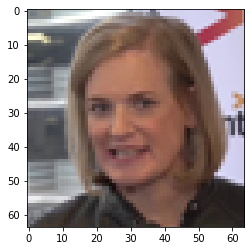

In [23]:
np.min(all_frames[0])
plt.imshow(np.transpose(((all_frames[0] + 1) * 127.5).astype(np.uint8), (1, 2, 0)))
plt.imshow(np.transpose(((src_img_list[0].cpu().numpy()[0] + 1) * 127.5).astype(np.uint8), (1, 2, 0)))
plt.show()

img_utils.sequence2gif(src_img_list, img_size=cfg.img_model.image_size, save_fn='src')
img_utils.sequence2gif(imgs=all_frames, img_size=cfg.img_model.image_size, save_fn='test')